In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import urlparse
import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../datasets/cleaned_comics_data.csv')

In [3]:
df.head()

,title,post,subreddit,up_votes,up_vote_ratio,clean_title,clean_post,clean_text,title_length,post_length,title_word_count,post_word_count,post_has_text
0,"weekly discussion thread: comics, tv, and more...",hey there honorary justice league members - it...,DCcomics,16,0.84,weekly discussion thread comics tv and more ap...,hey there honorary justice league members it ’...,weekly discussion thread comics tv and more ap...,98,4827.0,17,355.0,1
1,dead boy detectives megathread,# [***dead boy detectives***] (https://m.media...,DCcomics,12,0.80,dead boy detectives megathread,dead boy detectives \n\n time date april 25 20...,dead boy detectives megathread dead boy detect...,30,1957.0,4,132.0,1
2,[comic excerpt] tim realizes he's fallen in lo...,NaN,DCcomics,470,0.96,comic excerpt tim realizes he 's fallen in lov...,NaN,comic excerpt tim realizes he 's fallen in lov...,80,0.0,13,0.0,0
3,[comic excerpt] bros really thought they could...,NaN,DCcomics,65,0.90,comic excerpt bros really thought they could d...,NaN,comic excerpt bros really thought they could d...,119,0.0,20,0.0,0
4,"[discussion] it’s donna troy’s birthday, say s...",artist: https://www.tumblr.com/fatimajpeg/6998...,DCcomics,132,0.99,discussion it ’s donna troy ’s birthday say so...,artist,discussion it ’s donna troy ’s birthday say so...,69,86.0,10,2.0,1


### Make the Subreddit a numeric so Marvel = 1

In [4]:
df['subreddit'].value_counts()

subreddit
DCcomics    844
Marvel      831
Name: count, dtype: int64

In [5]:
df['subreddit'].replace( {'DCcomics' : 0, 'Marvel' : 1}, inplace = True )

In [6]:
df['subreddit'].value_counts()

subreddit
0    844
1    831
Name: count, dtype: int64

### Baseline score is 50%

In [7]:
df['subreddit'].value_counts(normalize = True)

subreddit
0    0.503881
1    0.496119
Name: proportion, dtype: float64

In [8]:
# Need to rename subreddit to differentiate between the word subreddit that appears in the corpus and the column
df.rename( {'subreddit' : 'subreddit_indicator' }, axis = 1, inplace = True )
df.columns

Index(['title', 'post', 'subreddit_indicator', 'up_votes', 'up_vote_ratio',
       'clean_title', 'clean_post', 'clean_text', 'title_length',
       'post_length', 'title_word_count', 'post_word_count', 'post_has_text'],
      dtype='object')

### Create `X` and `y` and do train_test_split

In [9]:
X = df['clean_text']
y = df['subreddit_indicator']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 616, stratify = y)
    # Random state of 616 in honor of Marvel home universe
    # Even though it's fairly balanced, will still stratify

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1256,), (419,), (1256,), (419,))

#### Running a Count Vectorizer over a Logistic Regression

In [12]:
pipe = Pipeline([
    ('cvec', CountVectorizer() ),
    ('logr', LogisticRegression() )
])

In [13]:
pipe_params = {
    'cvec__stop_words' : [None, 'english'],
    'cvec__max_features' : [2000, 3000, 4000, 5000, 6000], 
    'cvec__min_df' : [2, 4, 6],
    'cvec__ngram_range' : [ (1,1), (1,2), (1,3) ], #Look for not just individual words but word patterns like "Dark Knight Rises", "Avengers Infinity War")
}

In [14]:
gs = GridSearchCV(pipe, pipe_params, n_jobs = -1)

In [15]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [2000, 3000, 4000, 5000, 6000],
                         'cvec__min_df': [2, 4, 6],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english']})

In [16]:
gs.best_score_

0.9227660785429709

In [17]:
gs.best_params_

{'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [18]:
gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=3000, min_df=2,
                                 stop_words='english')),
                ('logr', LogisticRegression())])

In [19]:
gs.best_estimator_.named_steps

{'cvec': CountVectorizer(max_features=3000, min_df=2, stop_words='english'),
 'logr': LogisticRegression()}

In [20]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9952229299363057, 0.9474940334128878)

### This model can predict the reddit thread with 94.7% accuracy

### To Visualize Bag of Words, need to recreate the Count Vectorizer with same hyperparameters as the best estimator

In [21]:
cvec2 = CountVectorizer(max_features = 3000,
                       min_df = 2,
                       ngram_range = (1,1),
                       stop_words = 'english')

In [22]:
status_words = cvec2.fit_transform(X)
status_words

<1675x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 28864 stored elements in Compressed Sparse Row format>

In [23]:
words_df = pd.DataFrame(status_words.todense(), columns = cvec2.get_feature_names_out() )
words_df

,000,001,10,100,1064,1067,1084,10th,11,113,...,younger,youtube,ysmault,yuji,zatanna,zdarsky,zemo,zero,zod,zone
0,0,0,0,0,0,0,2,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
word_freq = pd.concat([y, words_df], axis = 1, join = 'inner')
word_freq

,subreddit_indicator,000,001,10,100,1064,1067,1084,10th,11,...,younger,youtube,ysmault,yuji,zatanna,zdarsky,zemo,zero,zod,zone
0,0,0,0,0,0,0,0,2,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1671,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1672,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1673,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 50 Most Frequent Features (Words/Bigrams) in Marvel Posts

In [25]:
marvel_words = word_freq[word_freq['subreddit_indicator'] == 1].drop(columns = 'subreddit_indicator')
marvel_words.sum().reset_index().sort_values(0, ascending = False)[0:50]

,index,0
1702,marvel,259
1683,man,211
1600,like,189
1730,men,187
607,comics,178
2441,spider,177
333,avengers,159
1492,just,128
1852,new,110
1532,know,109


### 50 Most Frequent Features (Words/Bigrams) in DC Posts

In [26]:
dc_words = word_freq[word_freq['subreddit_indicator'] == 0].drop(columns = 'subreddit_indicator')
dc_words.sum().reset_index().sort_values(0, ascending = False)[0:50]

,index,0
364,batman,345
790,dc,300
607,comics,251
606,comic,233
2563,superman,231
1600,like,230
1492,just,205
1852,new,194
2131,read,182
1532,know,139


In [27]:
probabilities = pd.DataFrame(gs.predict_proba(X_test), index = X_test.index)
probabilities

,0,1
301,1.000000,1.876053e-08
1361,0.209998,7.900016e-01
1655,0.120164,8.798365e-01
867,0.057355,9.426449e-01
766,0.450996,5.490039e-01
...,...,...
1580,0.094423,9.055771e-01
174,0.814362,1.856378e-01
1491,0.025459,9.745411e-01
952,0.000264,9.997357e-01


In [28]:
pred = gs.predict(X_test)
pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,

In [29]:
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, pred).ravel()

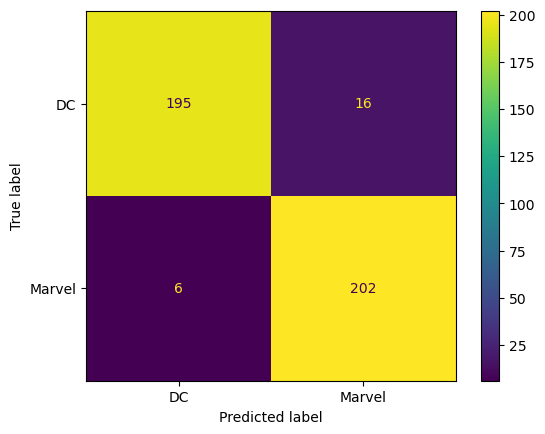

In [30]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test,
                                      display_labels = ['DC', 'Marvel']); #Adding labels to identify which company is which

In [31]:
(202 + 195) / (202 + 195 + 16 + 6)

0.9474940334128878

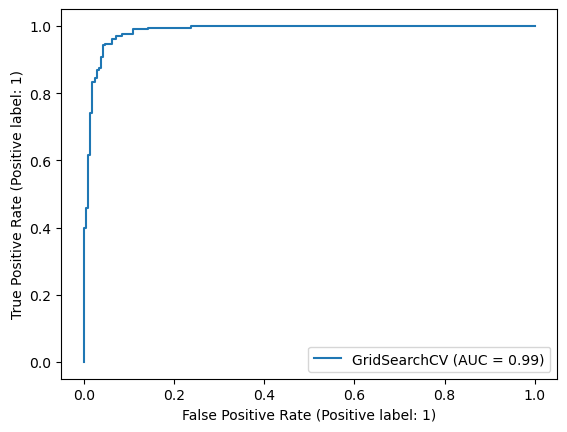

In [32]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

In [33]:
gs.best_estimator_.named_steps.cvec.get_feature_names_out()

array(['10', '100', '1064', ..., 'zero', 'zone', 'zucco'], dtype=object)

In [34]:
#The text it is predicting incorrectly: https://stackoverflow.com/questions/71928062/identifying-misclassified-raw-data-in-after-machine-learning-in-python
X_test[y_test != pred]

766             robin mentions his grandpa ra 's al ghul 
586     how many lobo compendium will there be first o...
227     is the new 52 canon i thought the new 52 was l...
246     the flash series i realize why i stop watching...
1096    any good digital tasm and x men collections i ...
366     other marvel taking a jab at dc comics for ide...
538     james tynion iv returns to nice house on the l...
1628    is what modern spider- man run is worth readin...
553     what are some fictional characters in dc like ...
154     can you recommend a good short comic from the ...
725     i prefer to read clark and bruce as supporting...
1654    is there any difference between livewires trad...
509     who did really like watchemen the movie honest...
214            \n josh keaton 's web warriors 🕸 ️ \n \n\n
342     merchandise static shock figure collection i '...
127     form and function is there an in canon explana...
1470    do i read thanos 2016 before infinity wars 201...
1604    who 's

In [35]:
incorrect = pd.DataFrame(X_test[y_test != pred])
incorrect

,clean_text
766,robin mentions his grandpa ra 's al ghul
586,how many lobo compendium will there be first o...
227,is the new 52 canon i thought the new 52 was l...
246,the flash series i realize why i stop watching...
1096,any good digital tasm and x men collections i ...
366,other marvel taking a jab at dc comics for ide...
538,james tynion iv returns to nice house on the l...
1628,is what modern spider- man run is worth readin...
553,what are some fictional characters in dc like ...
154,can you recommend a good short comic from the ...


### These are the 22 predictions it is getting wrong. 

13 of the 22 the model gets wrong, the model is very confident in its prediction (over 66% probability of predicting the wrong subreddit)

In [36]:
pd.set_option('display.max_colwidth', 500)

incorrect.join(df['subreddit_indicator'])
incorrect_df = incorrect.join([df['subreddit_indicator'], probabilities]).sort_values(1)
print(len(incorrect_df))
incorrect_df

22


,clean_text,subreddit_indicator,0,1
1470,do i read thanos 2016 before infinity wars 2018 i ’ve been wanting to read donny cates universe of venom thor and etc and also wanted to read infinity wars before it wondering if reading the thanos 2016 1 12 leads into infinity wars or does it cover anything in donny cates run if not what does 1 12 cover of the thanos 2016 run,1,0.816448,0.183552
1604,who 's autograph is this found a french black panther comic \n does anyone know the signature is on the cover,1,0.733592,0.266408
1096,any good digital tasm and x men collections i want to start reading more comics and i want to start from the lee era are there any good digital collections of the stories by that i mean ones that cover from the lee era till the current days or at least ones that collect the most issues,1,0.684338,0.315662
1654,is there any difference between livewires trades with blue or red spines i 've been interested in picking up the livewires trade but i always see two a blue and a red spine \n\n i just wanted to know if there 's a difference and what it is i wanna make sure i 'm not gon na end up getting a black and white reprint or a smaller copy or something,1,0.681018,0.318982
1023,took a stab at making my own action figure comic book cover,1,0.654353,0.345647
1628,is what modern spider- man run is worth reading i was wanting to read nick spencer ’s run of sm but heard he messes up his story or it ’s really bad etc and just wondering if there ’s a better recent current ongoing sm comic that i should read \n,1,0.592614,0.407386
553,what are some fictional characters in dc like characters that inside the universe but not really real inside their universe,0,0.483839,0.516161
766,robin mentions his grandpa ra 's al ghul,0,0.450996,0.549004
227,is the new 52 canon i thought the new 52 was like marvel 's ultimate universe but for dc but i keep seeing stuff from it referenced in other books and got confused is that what rebirth is supposed to be a fusion of both or,0,0.430649,0.569351
246,the flash series i realize why i stop watching it before and why i stop watching again now haha so i remember when the flash series was on it 's season 2 i was so into it then i stopped watching after that season then now 2024 i saw it again on netflix so i decided to start watching it again from the beginning and i was enjoying it i kinda ask myself why did i stop watching this awesome series what made me not continue watching it then on the last part of season 2 when barry go save her moth...,0,0.397361,0.602639
